# 0. Introduction

This is a 5 layers Sequential Convolutional Neural Network for digits recognition trained on MNIST dataset. I choosed to build it with keras API (Tensorflow backend) which is very intuitive. Firstly, I will prepare the data (handwritten digits images) then i will focus on the CNN modeling and evaluation.

I achieved 99.671% of accuracy with this CNN trained in 2h30 on a single CPU (i5 2500k). For those who have a >= 3.0 GPU capabilites (from GTX 650 - to recent GPUs), you can use tensorflow-gpu with keras. Computation will be much much faster !!!

**For computational reasons, i set the number of steps (epochs) to 2, if you want to achieve 99+% of accuracy set it to 30.**

This Notebook follows three main parts:

* The data preparation
* The CNN modeling and evaluation
* The results prediction and submission




<img src="http://img1.imagilive.com/0717/mnist-sample.png" ></img>

## 1. Import Modules

In [1]:
# Import the necessary libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import mnist

sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


# 2. Data preparation

## 2.1 Download Data

In [2]:
# Download Data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

Y_train = train["label"]
X_train = train.drop(labels = ["label"], axis = 1) 

## 2.2 Load more Data sets

In [3]:
# Load more data sets, if there is no such data, validation accuracy = 0.9964
# With this batch of data, the validation accuracy can reach 0.9985

(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()

train1 = np.concatenate([x_train1, x_test1], axis=0)
y_train1 = np.concatenate([y_train1, y_test1], axis=0)

Y_train1 = y_train1
X_train1 = train1.reshape(-1, 28*28)

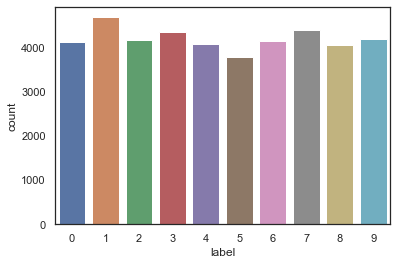

In [4]:
# Print data histogram
g = sns.countplot(Y_train)

## 2.3 Normalization (정규화)

In [5]:
# Normalize data to make CNN faster
X_train = X_train / 255.0
test = test / 255.0

X_train1 = X_train1 / 255.0

## 2.4 Reshape 
### CNN을 하기 위한 4차원 reshape

In [6]:
# Reshape Picture is 3D array (height = 28px, width = 28px , canal = 1)
X_train = np.concatenate((X_train.values, X_train1))
Y_train = np.concatenate((Y_train, Y_train1))

In [7]:
X_train = X_train.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

## 2.5 Label encoding 
### 정답 Labeling을 위한 one hot encoding

In [8]:
# Convert label to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

## 2.6 Split training and valdiation set 

In [9]:
## 2.6 Split training and valdiation set 
# 훈련데이터와 테스트 데이터를 9:1 비율로 random_state로 나눔.

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

Since we have 42 000 training images of balanced labels (see 2.1 Load data), a random split of the train set doesn't cause some labels to be over represented in the validation set. Be carefull with some unbalanced dataset a simple random split could cause inaccurate evaluation during the validation. 

To avoid that, you could use stratify = True option in train_test_split function (**Only for >=0.17 sklearn versions**).

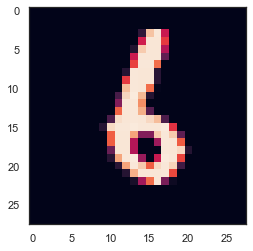

In [10]:
# Draw an example of a data set to see
g = plt.imshow(X_train[189][:,:,0])

# 첫번째 훈련데이터를 matplotlib로 가져와서 확인 ( RGB중 R부분만 확인 [:,:,0])

# 3. CNN
## 3.1 Define the model

I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important. 

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting. 

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network. 

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [11]:
#Creating CNN model
"""
  [[Conv2D->relu]*2 -> BatchNormalization -> MaxPool2D -> Dropout]*2 -> 
  [Conv2D->relu]*2 -> BatchNormalization -> Dropout -> 
  Flatten -> Dense -> BatchNormalization -> Dropout -> Out
"""
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(10, activation = "softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)       

## 3.2 Set the optimizer and annealer

Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm.

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss. 

I choosed RMSprop (with default values), it is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate.
We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop.

The metric function "accuracy" is used is to evaluate the performance our model.
This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [13]:
# Define the optimizer ( 현재 RMSprop 사용 중)
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [14]:
# Compile model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# 분류문제이기 때문에 오차함수로 loss = "categorical_crossentropy" 를 사용 중
# 정확도로 평가 함 metrics=["accuracy"]

In [15]:
# Audjusting learning rate
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [16]:
# Adjusting epochs and batch_size
# 현재 50에폭 128 Batch_size
epochs = 50
batch_size = 128

## 3.3 Data augmentation (데이터 증가)

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered 
The scale is not the same (some who write with big/small numbers)
The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales(흑백출력), horizontal flips(상하반전), vertical flips(좌우 반전), random crops(랜덤으로 자르기), color jitters(컬러 변조), translations, rotations(회전), and much more. 

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

The improvement is important : 
   - Without data augmentation i obtained an accuracy of 98.114%
   - With data augmentation i achieved 99.67% of accuracy

오버피팅 문제를 막기위해서 ImageDataGenerator를 이용하여 임의의 숫자 image 데이터들을 만들 것이다.   
이 과정을 통해서 98.114%에서 99.67%로 정확도가 상승하였다.  

In [ ]:
# Without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [17]:
# Data Augmentation 
datagen = ImageDataGenerator(
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

In [19]:
#Prediction model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
787/787 [==============================] - 20s 25ms/step - loss: 0.0490 - accuracy: 0.9851 - val_loss: 0.0395 - val_accuracy: 0.9884
Epoch 2/50
  7/787 [..............................] - ETA: 19s - loss: 0.0329 - accuracy: 0.9888

C:\anaconda3\envs\tf2.0-gpu\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


787/787 [==============================] - 20s 26ms/step - loss: 0.0389 - accuracy: 0.9882 - val_loss: 0.0237 - val_accuracy: 0.9929
Epoch 3/50
787/787 [==============================] - 20s 25ms/step - loss: 0.0322 - accuracy: 0.9904 - val_loss: 0.0218 - val_accuracy: 0.9941
Epoch 4/50
787/787 [==============================] - 20s 26ms/step - loss: 0.0293 - accuracy: 0.9911 - val_loss: 0.0195 - val_accuracy: 0.9946
Epoch 5/50
787/787 [==============================] - 20s 25ms/step - loss: 0.0266 - accuracy: 0.9921 - val_loss: 0.0173 - val_accuracy: 0.9952
Epoch 6/50
787/787 [==============================] - 20s 25ms/step - loss: 0.0250 - accuracy: 0.9926 - val_loss: 0.0165 - val_accuracy: 0.9942
Epoch 7/50
787/787 [==============================] - 20s 25ms/step - loss: 0.0229 - accuracy: 0.9932 - val_loss: 0.0149 - val_accuracy: 0.9955
Epoch 8/50
787/787 [==============================] - 20s 25ms/step - loss: 0.0226 - accuracy: 0.9930 - val_loss: 0.0139 - val_accuracy: 0.9961
Epo

# 4. Evaluate the model
## 4.1 Training and validation curves

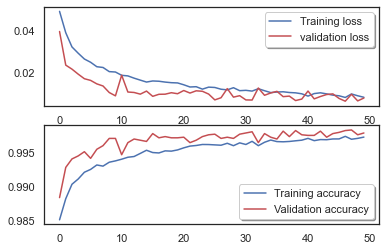

In [21]:
# Draw the loss and accuracy curves of the training set and the validation set.
# Can judge whether it is under-fitting or over-fitting
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

The code below is for plotting loss and accuracy curves for training and validation. Since, i set epochs = 2 on this notebook .
I'll show you the training and validation curves i obtained from the model i build with 30 epochs (2h30)

<img src="http://img1.imagilive.com/0717/mnist_099671_train_val_loss_acc.png"></img>

The model reaches almost 99% (98.7+%) accuracy on the validation dataset after 2 epochs. The validation accuracy is greater than the training accuracy almost evry time during the training. That means that our model dosen't not overfit the training set.

Our model is very well trained  !!! 

<img src="http://img1.imagilive.com/0717/accuracies1de.jpg"/>

## 4.2 Confusion matrix

Confusion matrix can be very helpfull to see your model drawbacks.

I plot the confusion matrix of the validation results.

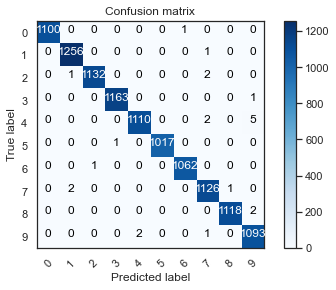

In [23]:
# Draw a confusion matrix that can be used to observe high false positives

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

Here we can see that our CNN performs very well on all digits with few errors considering the size of the validation set (4 200 images).

However, it seems that our CNN has some little troubles with the 4 digits, hey are misclassified as 9. Sometime it is very difficult to catch the difference between 4 and 9 when curves are smooth.

4와 9의 차이를 비교적 잘 못잡아내는것 같다.    
특히, 4와 9사이의 커브(굴곡)이 부드러우면 차이를 잘 못잡아내는 것 것 같다.  

Let's investigate for errors. 

I want to see the most important errors . For that purpose i need to get the difference between the probabilities of real value and the predicted ones in the results.

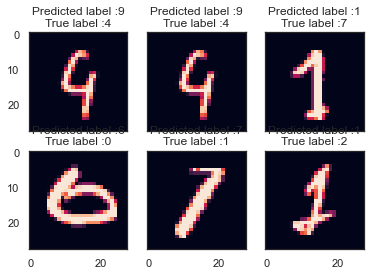

In [24]:
# Show some wrong results, and the difference between the predicted label and the real labe
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

The most important errors are also the most intrigous. 

For those six case, the model is not ridiculous. Some of these errors can also be made by humans, especially for one the 9 that is very close to a 4. The last 9 is also very misleading, it seems for me that is a 0.

In [25]:
# Make predictions about test sets
results = model.predict(test)

# Convert one-hot vector to number
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

### Save the final result in cnn_mnist_submission.csv

In [26]:
# Save the final result in cnn_mnist_submission.csv
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("E:\kaggle\digit-recognizer\submission\\cnn_mnist_submission_99.999.csv",index=False)